# Notes

name of spatial domains are renamed based on their distance to brain boundaries in the figures of our paper

# Load Modules

In [1]:
import GraphPCA as sg
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import squidpy as sq
import scipy
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances as pair
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.neighbors import kneighbors_graph

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline

# Load data

These two files generated in `benchmark` step

In [3]:
raw_counts = pd.read_csv('../../raw_data/merfish_cortex/merfish_selected_exp.csv', index_col=0)
raw_counts.head()

,Cell_0,Cell_1,Cell_2,Cell_3,Cell_4,Cell_5,Cell_6,Cell_7,Cell_8,Cell_9,...,Cell_14851,Cell_14852,Cell_14853,Cell_14854,Cell_14855,Cell_14856,Cell_14857,Cell_14858,Cell_14859,Cell_14860
index,,,,,,,,,,,,,,,,,,,,,
1700022I11Rik,0.0,0.000000,0.000000,0.0,0.000000,1.121013,0.000000,0.0,0.00000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1810046K07Rik,0.0,0.000000,0.532007,0.0,0.000000,0.000000,0.538767,0.0,0.00000,0.000000,...,0.000000,0.000000,0.0,0.578538,0.0,0.000000,0.000000,0.000000,0.662937,0.0
5031425F14Rik,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
5730522E02Rik,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,1.509003,...,0.000000,0.000000,0.0,0.000000,0.0,0.677113,0.384885,0.000000,0.000000,0.0
Acta2,0.0,0.439173,1.064013,0.0,1.409204,0.000000,0.000000,0.0,1.45771,0.000000,...,1.648172,1.122485,0.0,1.157075,0.0,0.000000,0.000000,3.135546,0.662937,0.0


In [4]:
# no genes with zero express
sum(raw_counts.values.sum(axis=1)==0)

0

In [5]:
np.isnan(raw_counts.values).sum()

0

In [6]:
print(raw_counts.shape)

(254, 14861)


In [7]:
ontrac_input = pd.read_csv('../../raw_data/merfish_cortex/merfish_selected_meta.csv')
print(ontrac_input.shape)
ontrac_input.head()

(14861, 8)


,Cell_ID,Cell_Type,x,y,Sample,cortical_depth,Cell_NTScore,label
0,Cell_0,L5 ET,-3145.779407,3884.950901,mouse2_slice169,667.210907,0.402788,L5_ET_3
1,Cell_1,L2/3 IT,-2972.356481,2558.893648,mouse2_slice169,364.835270,0.783290,L23_IT_4
2,Cell_2,L4/5 IT,-100.569506,2776.927999,mouse2_slice99,1094.584971,0.646011,L45_IT_1
3,Cell_3,L6 CT,-4048.311904,2090.110198,mouse2_slice169,1270.628357,0.201171,L6_CT_2
4,Cell_4,L6 IT,-3849.190754,2475.294401,mouse2_slice169,1151.161772,0.221022,L6_IT_3


# run Graph PCA

In [8]:
samples = ontrac_input['Sample'].unique().tolist()

In [9]:
Batch_list = []
adj_list = []


for sample in samples:
    print(sample)
    
    # extract
    cells = ontrac_input[ontrac_input['Sample'] == sample]['Cell_ID']
    sample_counts = raw_counts[cells]
    
    # create adata
    adata = ad.AnnData(sample_counts.T)
    adata.obs = adata.obs.join(ontrac_input.set_index('Cell_ID')[['Cell_Type','Sample','label']])
    location = ontrac_input[ontrac_input['Sample'] == sample][['x','y']].values
    adata.uns["spatial"] = location
    
    # Constructing the spatial network
    n_neighbors = 7
    graph = kneighbors_graph(np.asarray(location), int(n_neighbors), metric='euclidean',
                                     metric_params={}, include_self=False)
    graph = 0.5 * (graph + graph.T)

    adata.uns["adj"] = graph
    adata.obsm["spatial"] = location
    
    # Normalization
    sc.pp.filter_genes(adata, min_cells=20)
    sc.experimental.pp.normalize_pearson_residuals(adata)
    sc.pp.scale(adata)

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)
    
    print(adata.X.shape)
    print(graph.shape)

mouse2_slice169
(5213, 254)
(5213, 5213)
mouse2_slice99
(5240, 254)
(5240, 5240)
mouse1_slice301
(4408, 254)
(4408, 4408)


In [10]:
adata_concat = ad.concat(Batch_list, label="Sample", keys=samples)
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (14861, 254)


In [12]:
%%time

from functools import reduce

adj_concat = reduce(scipy.linalg.block_diag, (x.todense() for x in adj_list))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)
adata_concat.uns['network'] = scipy.sparse.csr_matrix(adj_concat)

CPU times: user 2.81 s, sys: 739 ms, total: 3.54 s
Wall time: 3.57 s


In [13]:
%%time

Z,_ = sg.Run_GPCA(adata_concat, network=adata_concat.uns['network'], n_components = 50, method = "knn", _lambda = 0.6,n_neighbors=7,
               save_reconstruction=True)
adata_concat.obsm["GraphPCA"] = Z
print(Z.shape)

(14861, 50)
CPU times: user 2min 13s, sys: 3.45 s, total: 2min 16s
Wall time: 40.4 s


In [14]:
estimator = KMeans(n_clusters=6)
res = estimator.fit(Z[:,:])
lable_pred=res.labels_
adata_concat.obs["GPCA_pred"]= lable_pred
adata_concat.obs["GPCA_pred"] = adata_concat.obs["GPCA_pred"].astype('category')
adata_concat.obsm["GraphPCA"] = Z


In [15]:
adata_concat.obs.head()

,Cell_Type,Sample,label,GPCA_pred
Cell_0,L5 ET,mouse2_slice169,L5_ET_3,0
Cell_1,L2/3 IT,mouse2_slice169,L23_IT_4,1
Cell_3,L6 CT,mouse2_slice169,L6_CT_2,2
Cell_4,L6 IT,mouse2_slice169,L6_IT_3,2
Cell_6,L6 CT,mouse2_slice169,L6_CT_2,2


In [16]:
adata_concat.obs = adata_concat.obs.join(ontrac_input.set_index('Cell_ID')[['x','y','Cell_NTScore']])
adata_concat.obs.head()

,Cell_Type,Sample,label,GPCA_pred,x,y,Cell_NTScore
Cell_0,L5 ET,mouse2_slice169,L5_ET_3,0,-3145.779407,3884.950901,0.402788
Cell_1,L2/3 IT,mouse2_slice169,L23_IT_4,1,-2972.356481,2558.893648,0.783290
Cell_3,L6 CT,mouse2_slice169,L6_CT_2,2,-4048.311904,2090.110198,0.201171
Cell_4,L6 IT,mouse2_slice169,L6_IT_3,2,-3849.190754,2475.294401,0.221022
Cell_6,L6 CT,mouse2_slice169,L6_CT_2,2,-3545.562407,3836.959396,0.200466


In [17]:
adata_concat.obs['GPCA_pred'] = adata_concat.obs['GPCA_pred'].astype('category')

In [23]:
adata_concat

AnnData object with n_obs × n_vars = 14861 × 254
    obs: 'Cell_Type', 'Sample', 'label', 'GPCA_pred', 'x', 'y', 'Cell_NTScore'
    uns: 'edgeList', 'network'
    obsm: 'spatial', 'GraphPCA'
    layers: 'GraphPCA_ReX'

In [24]:
del adata_concat.uns['edgeList']
adata_concat.write_h5ad('GraphPCA_merfish_selected.h5ad')

In [25]:
adata_concat.obs.to_csv('merfish_selected_GPCA.csv')

In [9]:
adata_concat = sc.read_h5ad('GraphPCA_merfish_selected.h5ad')

mouse2_slice169
mouse2_slice99
mouse1_slice301


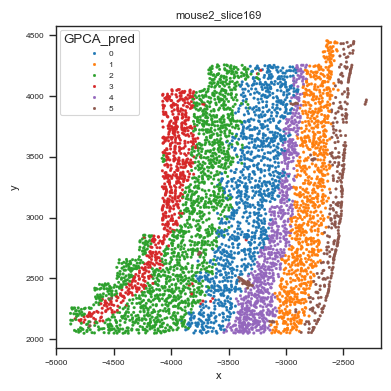

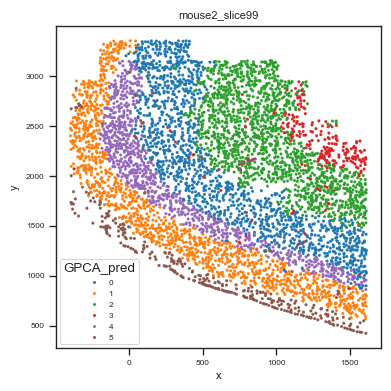

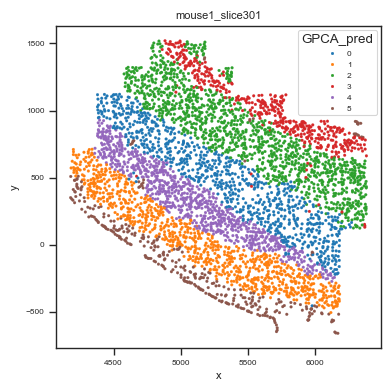

In [10]:
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 8,
                             'axes.labelsize': 8,
                             'xtick.labelsize': 6,
                             'ytick.labelsize': 6,
                             'legend.fontsize': 6
                         }):
    for sample in samples:
        print(sample)
        fig, ax = plt.subplots(figsize=(4,4))
        sns.scatterplot(adata_concat.obs[adata_concat.obs['Sample']==sample],
                        x='x',
                        y='y',
                        hue='GPCA_pred',
                        s=4,
                        edgecolor=None,
                        ax=ax)
        ax.set_title(f'{sample}')
        fig.tight_layout()
        fig.savefig(f'GPCA_res_{sample}.pdf', transparent=True)

# marker gene expression

In [11]:
id_adata = adata_concat[[True if 'IT' in x else False for x in adata_concat.obs['Cell_Type']]]
id_adata

View of AnnData object with n_obs × n_vars = 5845 × 254
    obs: 'Cell_Type', 'Sample', 'label', 'GPCA_pred', 'x', 'y', 'Cell_NTScore'
    uns: 'network'
    obsm: 'GraphPCA', 'spatial'
    layers: 'GraphPCA_ReX'

In [12]:
id_adata.obs.head()

,Cell_Type,Sample,label,GPCA_pred,x,y,Cell_NTScore
Cell_1,L2/3 IT,mouse2_slice169,L23_IT_4,1,-2972.356481,2558.893648,0.783290
Cell_4,L6 IT,mouse2_slice169,L6_IT_3,2,-3849.190754,2475.294401,0.221022
Cell_10,L2/3 IT,mouse2_slice169,L23_IT_3,1,-2752.397907,3687.988901,0.799065
Cell_28,L4/5 IT,mouse2_slice169,L45_IT_5,0,-3024.441904,3929.880749,0.471379
Cell_29,L2/3 IT,mouse2_slice169,L23_IT_2,1,-2679.051909,2866.560151,0.883682


In [13]:
id_adata.X

ArrayView([[-0.10993218, -0.21024787, -0.07948362, ...,  0.25657862,
            -0.09579887, -0.12342923],
           [-0.19244294, -0.3661301 , -0.13618537, ...,  2.09398826,
            -0.01845038, -0.36520111],
           [ 4.55096883, -0.34821053, -0.12966322, ...,  0.97306569,
            -0.10406327, -0.35708146],
           ...,
           [-0.16740529, -0.24555446, -0.13381094, ...,  0.05370788,
            -0.12789327, -0.27782322],
           [-0.18120716,  1.03790299, -0.14518327, ...,  1.88627391,
             0.34749273, -0.19299008],
           [-0.17369273, -0.25482625, -0.13899159, ...,  0.11913867,
            -0.28421835, -0.28816385]])

In [14]:
id_adata.var_names.tolist().index('Rspo1')

185

In [15]:
id_adata.var_names.tolist().index('Fezf2')

82

In [28]:
id_adata.X[:,185]

ArrayView([-0.22526442, -0.39668613, -0.1932806 , ...,  2.9721112 ,
           -0.40878983, -0.09675964])

In [30]:
data_df = id_adata.obs[['Cell_Type','GPCA_pred', 'Cell_NTScore','label']]
data_df.head()


,Cell_Type,GPCA_pred,Cell_NTScore,label
Cell_1,L2/3 IT,1,0.783290,L23_IT_4
Cell_4,L6 IT,2,0.221022,L6_IT_3
Cell_10,L2/3 IT,1,0.799065,L23_IT_3
Cell_28,L4/5 IT,0,0.471379,L45_IT_5
Cell_29,L2/3 IT,1,0.883682,L23_IT_2


In [33]:
data_df['Rspo1'] = list(id_adata.X[:,185])
data_df['Fezf2'] = list(id_adata.X[:,82])
data_df.head()

,Cell_Type,GPCA_pred,Cell_NTScore,label,Rspo1,Fezf2
Cell_1,L2/3 IT,1,0.783290,L23_IT_4,-0.225264,-0.372867
Cell_4,L6 IT,2,0.221022,L6_IT_3,-0.396686,-0.665408
Cell_10,L2/3 IT,1,0.799065,L23_IT_3,-0.193281,-0.632137
Cell_28,L4/5 IT,0,0.471379,L45_IT_5,-0.387517,0.586662
Cell_29,L2/3 IT,1,0.883682,L23_IT_2,-0.320162,-0.535333


In [34]:
data_df['Cell_Type'].unique()

['L2/3 IT', 'L6 IT', 'L4/5 IT', 'L5 IT', 'L6 IT Car3']
Categories (5, object): ['L2/3 IT', 'L4/5 IT', 'L5 IT', 'L6 IT', 'L6 IT Car3']

In [35]:
data_df = data_df[data_df['label'].isin(['L23_IT_1','L23_IT_2','L23_IT_3','L23_IT_4','L23_IT_5',
                                         'L45_IT_1','L45_IT_2','L45_IT_3','L45_IT_4','L45_IT_5',
                                         'L5_IT_1','L5_IT_2','L5_IT_3','L5_IT_4',
                                         'L6_IT_1','L6_IT_2','L6_IT_3',])]
data_df.head()

,Cell_Type,GPCA_pred,Cell_NTScore,label,Rspo1,Fezf2
Cell_1,L2/3 IT,1,0.783290,L23_IT_4,-0.225264,-0.372867
Cell_4,L6 IT,2,0.221022,L6_IT_3,-0.396686,-0.665408
Cell_10,L2/3 IT,1,0.799065,L23_IT_3,-0.193281,-0.632137
Cell_28,L4/5 IT,0,0.471379,L45_IT_5,-0.387517,0.586662
Cell_29,L2/3 IT,1,0.883682,L23_IT_2,-0.320162,-0.535333


In [36]:
N = 20
data_df['Bins'] = pd.qcut(data_df['Cell_NTScore'], q=N, labels=[f'Bin_{20-i}' for i in range(N)])
data_df.head()


,Cell_Type,GPCA_pred,Cell_NTScore,label,Rspo1,Fezf2,Bins
Cell_1,L2/3 IT,1,0.783290,L23_IT_4,-0.225264,-0.372867,Bin_7
Cell_4,L6 IT,2,0.221022,L6_IT_3,-0.396686,-0.665408,Bin_18
Cell_10,L2/3 IT,1,0.799065,L23_IT_3,-0.193281,-0.632137,Bin_5
Cell_28,L4/5 IT,0,0.471379,L45_IT_5,-0.387517,0.586662,Bin_14
Cell_29,L2/3 IT,1,0.883682,L23_IT_2,-0.320162,-0.535333,Bin_1


In [37]:
print(data_df['Cell_NTScore'].min())
print(data_df['Cell_NTScore'].max())

0.1280593611643419
0.975664489452715


In [38]:
sorted(data_df['label'].unique().tolist())

['L23_IT_1',
 'L23_IT_2',
 'L23_IT_3',
 'L23_IT_4',
 'L23_IT_5',
 'L45_IT_1',
 'L45_IT_2',
 'L45_IT_3',
 'L45_IT_4',
 'L45_IT_5',
 'L5_IT_1',
 'L5_IT_2',
 'L5_IT_3',
 'L5_IT_4',
 'L6_IT_1',
 'L6_IT_2',
 'L6_IT_3']

In [39]:
data_df.pivot_table(index='Cell_Type',columns='Bins',aggfunc='size',fill_value=0)

Bins,Bin_20,Bin_19,Bin_18,Bin_17,Bin_16,Bin_15,Bin_14,Bin_13,Bin_12,Bin_11,Bin_10,Bin_9,Bin_8,Bin_7,Bin_6,Bin_5,Bin_4,Bin_3,Bin_2,Bin_1
Cell_Type,,,,,,,,,,,,,,,,,,,,
L2/3 IT,0,0,2,0,1,0,0,0,0,1,22,141,224,252,253,257,259,257,259,259
L4/5 IT,0,0,2,1,3,9,59,200,252,256,237,116,35,7,5,2,0,1,0,0
L5 IT,9,35,69,147,224,242,194,58,6,2,0,1,0,0,0,0,0,0,0,0
L6 IT,250,224,185,111,31,7,6,1,0,0,0,0,0,0,0,0,0,0,0,0
L6 IT Car3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
print(147/(147+111))
print(141/(141+116))

0.5697674418604651
0.5486381322957199


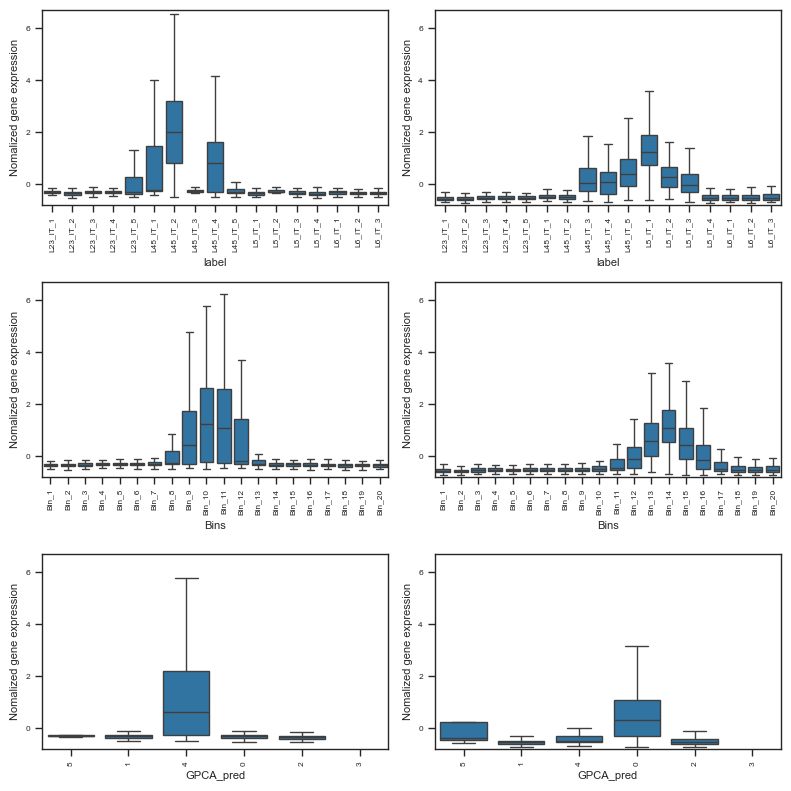

In [41]:
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 8,
                             'axes.labelsize': 8,
                             'xtick.labelsize': 6,
                             'ytick.labelsize': 6,
                             'legend.fontsize': 6
                         }):
    fig, axes = plt.subplots(3, 2, figsize=(8, 8))
    
    # Rspo1 origin paper
    sns.boxplot(data_df,
                x = 'label',
                y = 'Rspo1',
                order = [
                    'L23_IT_1',
                    'L23_IT_2',
                    'L23_IT_3',
                    'L23_IT_4',
                    'L23_IT_5',
                    'L45_IT_1',
                    'L45_IT_2',
                    'L45_IT_3',
                    'L45_IT_4',
                    'L45_IT_5',
                    'L5_IT_1',
                    'L5_IT_2',
                    'L5_IT_3',
                    'L5_IT_4',
                    'L6_IT_1',
                    'L6_IT_2',
                    'L6_IT_3',
                ],
                showfliers = False,
                ax = axes[0,0])
    axes[0,0].set_ylim(-0.8,6.7)
    axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation='vertical')
    axes[0,0].set_ylabel('Nomalized gene expression')
    
    # Fezf2 origin paper
    sns.boxplot(data_df,
                x = 'label',
                y = 'Fezf2',
                order = [
                    'L23_IT_1',
                    'L23_IT_2',
                    'L23_IT_3',
                    'L23_IT_4',
                    'L23_IT_5',
                    'L45_IT_1',
                    'L45_IT_2',
                    'L45_IT_3',
                    'L45_IT_4',
                    'L45_IT_5',
                    'L5_IT_1',
                    'L5_IT_2',
                    'L5_IT_3',
                    'L5_IT_4',
                    'L6_IT_1',
                    'L6_IT_2',
                    'L6_IT_3',
                ],
                showfliers = False,
                ax = axes[0,1])
    axes[0,1].set_ylim(-0.8,6.7)
    axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation='vertical')
    axes[0,1].set_ylabel('Nomalized gene expression')
    

    # Rspo1 ONTraC
    sns.boxplot(data_df,
                x = 'Bins',
                y = 'Rspo1',
                order = [f'Bin_{i+1}' for i in range(N)],
                showfliers = False,
                ax = axes[1,0])
    axes[1,0].set_ylim(-0.8,6.7)
    axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation='vertical')
    axes[1,0].set_ylabel('Nomalized gene expression')
    
    # Fezf2 ONTraC
    sns.boxplot(data_df,
                x = 'Bins',
                y = 'Fezf2',
                order = [f'Bin_{i+1}' for i in range(N)],
                showfliers = False,
                ax = axes[1,1])
    axes[1,1].set_ylim(-0.8,6.7)
    axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation='vertical')
    axes[1,1].set_ylabel('Nomalized gene expression')
    
    # Rspo1 GraphPCA
    sns.boxplot(data_df,
                x = 'GPCA_pred',
                y = 'Rspo1',
                order = [5, 1, 4, 0, 2, 3],
                showfliers = False,
                ax = axes[2,0])
    axes[2,0].set_ylim(-0.8,6.7)
    axes[2,0].set_xticklabels(axes[2,0].get_xticklabels(), rotation='vertical')
    axes[2,0].set_ylabel('Nomalized gene expression')
    
    # Fezf2 GraphPCA
    sns.boxplot(data_df,
                x = 'GPCA_pred',
                y = 'Fezf2',
                order = [5, 1, 4, 0, 2, 3],
                showfliers = False,
                ax = axes[2,1])
    axes[2,1].set_ylim(-0.8,6.7)
    axes[2,1].set_xticklabels(axes[2,1].get_xticklabels(), rotation='vertical')
    axes[2,1].set_ylabel('Nomalized gene expression')
    
    fig.tight_layout()
    fig.savefig(f'MERFISH_mark_gene_exp_by_all_three_method.pdf', transparent=True)